## Deep kernel learning example on STEM data
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/STEM/2_active_learning_dkl_COLAB-Hackathon.ipynb)


In [1]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git
!pip install pytemlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 852.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 23.0 MB/s eta 0:00:00
  Cloning https://github.com/pycroscopy/DTMicroscope.git to /tmp/pip-req-build-qc9ugxpk
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git /tmp/pip-req-build-qc9ugxpk
  Resolved https://github.com/pycroscopy/DTMicroscope.git to commit 3a7dcb03

In [2]:
!run_server_stem

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Server started and running in the background. Logs are being written to server.log.


# Active learning in STEM

One significant challenge in STEM is that it is not always possible to acquire spectroscopy across a dense grid of points due to the beam causing sample damage. Even in cases where there is little damage, this method is still highly wasteful. Instead, it is useful to be able to adaptively sample to maximize some property of interest. This example shows how deep kernel learning can be used for this adaptive sampling/optimization.

## Client side starts

In [3]:
!pip install atomai
!pip install gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:0

In [4]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from atomai.utils import get_coord_grid, extract_patches_and_spectra, extract_subimages
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gpax

In [5]:
# Connect to the microscope server
uri = "PYRO:microscope.server@localhost:9091"
mic_server = Pyro5.api.Proxy(uri)
out_dir = "."


In [6]:
### 2. Download data and register
!wget https://github.com/pycroscopy/DTMicroscope/raw/utk/data/STEM/SI/test_stem.h5
mic_server.initialize_microscope("STEM")
mic_server.register_data("test_stem.h5")


--2025-05-22 16:52:48--  https://github.com/pycroscopy/DTMicroscope/raw/utk/data/STEM/SI/test_stem.h5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/utk/data/STEM/SI/test_stem.h5 [following]
--2025-05-22 16:52:49--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/utk/data/STEM/SI/test_stem.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55702624 (53M) [application/octet-stream]
Saving to: ‘test_stem.h5’

test_stem.h5        100%[===================>]  53.12M   129MB/s    in 0.4s    

2025-05-22 16:52:50 (129 MB/s) - ‘test_stem.h5’ saved [55702624/55702624]



In [10]:
def load_image_and_features(img, window_size):
    coordinates = get_coord_grid(img, step = 1, return_dict=False)
    features_all, coords, _ = extract_subimages(img, coordinates, window_size)
    features_all = features_all[:,:,:,0]
    coords = np.array(coords, dtype=int)
    norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
    features = norm_(features_all)
    return features, coords

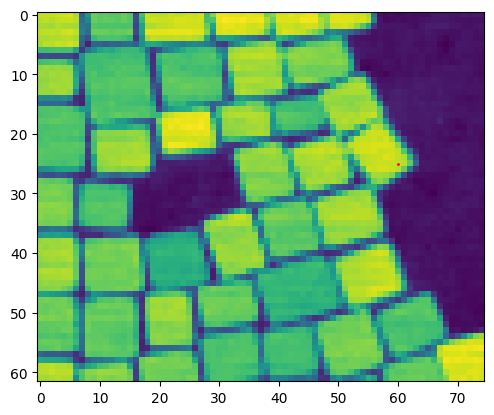

In [11]:
# Get overview image
array_list, shape, dtype = mic_server.get_overview_image()
img = np.array(array_list, dtype=dtype).reshape(shape)
features, indices_all = load_image_and_features(img, window_size=12)## cached so not run again

n, d1, d2 = features.shape
X = features.reshape(n, d1*d2)
plt.imshow(img)# shape is 55,70
plt.scatter(60, 25, s=1, c='r')

In [12]:
# use only 0.02% of grid data points as initial training points
(X_measured, X_unmeasured, indices_measured, indices_unmeasured) = train_test_split(
    X, indices_all, test_size=0.990, shuffle=True, random_state=3)

seed_points = len(X_measured)

print("Seed points: ", seed_points)

Seed points:  32


In [13]:
energy_range_01 = [0.35, 0.55]# dipole mode
energy_range_02 = [0.6, 0.75]# edge mode
energy_range_03 = [0.8, 1.0]# bulk mode
array_list, shape, dtype = mic_server.get_spectrum_image(spectrum_image_index ="Channel_001")
spectral_img = np.array(array_list, dtype=dtype).reshape(shape)
array_list, shape, dtype  = mic_server.get_spectrum_image_e_axis(spectrum_image_index ="Channel_001")
E_axis = np.array(array_list, dtype=dtype).reshape(shape)
e1a, e1b = abs(E_axis - energy_range_01[0]).argmin(), abs(E_axis - energy_range_01[1]).argmin()# 2 numbers
e2a, e2b = abs(E_axis - energy_range_02[0]).argmin(), abs(E_axis - energy_range_02[1]).argmin()# 2 numbers
e3a, e3b = abs(E_axis - energy_range_03[0]).argmin(), abs(E_axis - energy_range_03[1]).argmin()# 2 numbers


In [14]:
reference_y_pred = np.sum(spectral_img[:, :, e1a:e1b], axis=2)
# Normalize the entire array
norm_ = lambda x: (x - np.min(x)) / np.ptp(x)
reference_y_pred = norm_(reference_y_pred)

In [16]:
# run experiment on seed points
y_measured_unnor = []
for i in range (seed_points):
    array_list, shape, dtype  = mic_server.get_point_data(spectrum_image_index="Channel_001",x =  int(indices_measured[i, 0]), y = int(indices_measured[i, 1]))# note: the x and y should not be numpy objects
    spectrum = np.array(array_list, dtype=dtype).reshape(shape)
    current_y = spectrum[e1a:e1b].sum() # scalarizer
    y_measured_unnor.append(current_y)
    # time.sleep(0.5)

norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
y_measured = norm_(np.asarray(y_measured_unnor))

Text(0.5, 1.0, 'Seed Points')

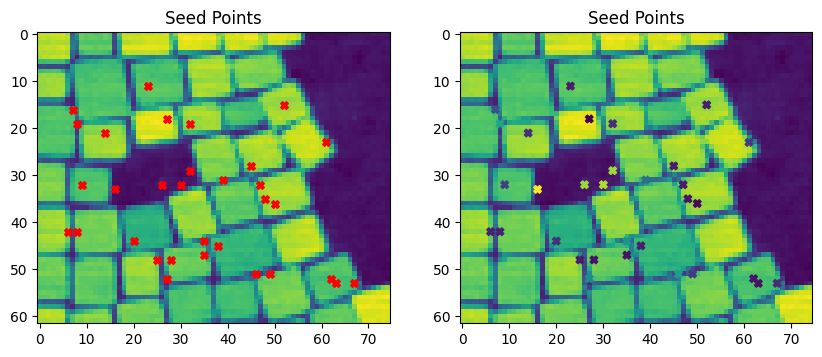

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].scatter(indices_measured[:, 1], indices_measured[:, 0], c="r", marker = "X", s=30)
axes[0].set_title('Seed Points')

axes[1].imshow(img)
axes[1].scatter(indices_measured[:, 1], indices_measured[:, 0], c=y_measured, marker = "X", s=30)
axes[1].set_title('Seed Points')





In [19]:
budget = 100

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_acquisition_and_dkl_prediction(
    indices_unmeasured, obj, img, dkl, key1, X, indices_all, reference_scalarizer, file_name, step
):
    """
    Plots the acquisition function values, DKL predictions, the original image,
    and the reference scalarizer, then saves the plot as a PNG file.

    Parameters:
    - indices_unmeasured: np.ndarray of unmeasured indices.
    - obj: np.ndarray of acquisition function values.
    - img: np.ndarray, base image to overlay predictions on.
    - dkl: DKL model instance with a predict method.
    - key1: Random state or key used in the DKL predict function.
    - X: np.ndarray of input data points for DKL prediction.
    - indices_all: np.ndarray of all indices used for prediction.
    - reference_scalarizer: np.ndarray, reference scalarizer values.
    - file_name: str, the file name (without extension) to save the plot as PNG.
    """
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

    # Create an image to display acquisition function values using imshow
    acq_img = np.zeros_like(img, dtype=float)  # Initialize a grid of zeros with the same shape as the original image

    # Fill in the acquisition values at the unmeasured indices
    for idx, (i, j) in enumerate(indices_unmeasured):
        acq_img[i, j] = obj[idx]

    # Plot the acquisition function values using imshow
    im1 = ax[0, 0].imshow(acq_img, cmap='viridis')
    cbar1 = fig.colorbar(im1, ax=ax[0, 0], orientation='vertical', fraction=0.046, pad=0.04)
    cbar1.set_label('Acquisition Function Value')

    # Highlight the next point to measure
    next_point = indices_unmeasured[obj.argmax()]
    ax[0, 0].scatter(next_point[1], next_point[0], marker='x', c='k', s=100)
    ax[0, 0].set_title("Acquisition Function Values")
    ax[0, 0].set_xlabel('X Index')
    ax[0, 0].set_ylabel('Y Index')

    # Plot the DKL prediction
    y_pred_img = np.zeros((img.shape[0], img.shape[1]))
    y_pred_mean, y_pred_std = dkl.predict(key1, np.array(X))

    # Fill the prediction image with predicted mean values
    for j in range(len(indices_all)):
        y_pred_img[indices_all[j][0], indices_all[j][1]] = y_pred_mean[j]

    im2 = ax[0, 1].imshow(y_pred_img, cmap='plasma')
    cbar2 = fig.colorbar(im2, ax=ax[0, 1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar2.set_label('Predicted Mean Value')

    ax[0, 1].set_title("DKL Prediction")
    ax[0, 1].set_xlabel('X Index')
    ax[0, 1].set_ylabel('Y Index')

    # Plot the original image
    ax[1, 0].imshow(img, cmap='gray')
    ax[1, 0].set_title("Original Image")
    ax[1, 0].set_xlabel('X Index')
    ax[1, 0].set_ylabel('Y Index')

    # Plot the reference scalarizer
    im3 = ax[1, 1].imshow(reference_scalarizer, cmap='inferno')
    cbar3 = fig.colorbar(im3, ax=ax[1, 1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar3.set_label('Reference Scalarizer')

    ax[1, 1].set_title("Reference Scalarizer")
    ax[1, 1].set_xlabel('X Index')
    ax[1, 1].set_ylabel('Y Index')

    # Calculate MSE between the DKL prediction and the reference scalarizer
    mse = mean_squared_error(reference_scalarizer.flatten(), y_pred_img.flatten())
    print(f"Mean Squared Error between DKL Prediction and Reference Scalarizer: {mse:.4f}")
    fig.suptitle(f" Step_{step}_Mean Squared Error: {mse:.4f}", fontsize=16)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{file_name} + 'mse' {mse:.4f} .png")
    # plt.close(fig)  # Close the figure to free memory

data_dim = X_measured.shape[-1]
key1, key2 = gpax.utils.get_keys()

100%|██████████| 100/100 [00:03<00:00, 25.38it/s, init loss: 13203.1416, avg. loss [96-100]: 12498.6045]



Inferred GP kernel parameters
k_length         [2.2326    2.2549999]
k_scale          0.24069999
noise            0.022699999
Mean Squared Error between DKL Prediction and Reference Scalarizer: 0.0483


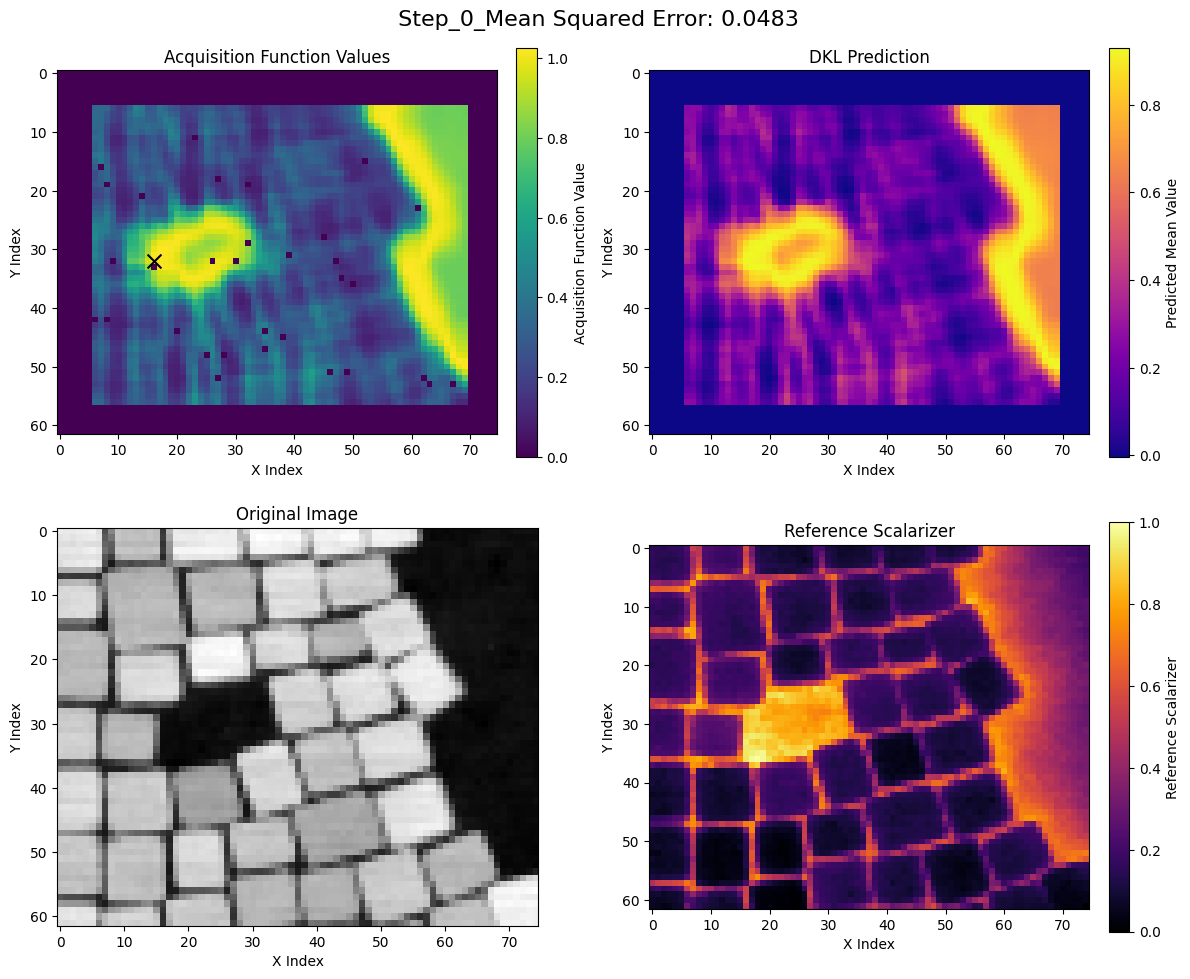

100%|██████████| 100/100 [00:04<00:00, 20.81it/s, init loss: 13204.3662, avg. loss [96-100]: 12511.3623]



Inferred GP kernel parameters
k_length         [2.0618 2.0937]
k_scale          0.23249999
noise            0.0262
Mean Squared Error between DKL Prediction and Reference Scalarizer: 0.0456


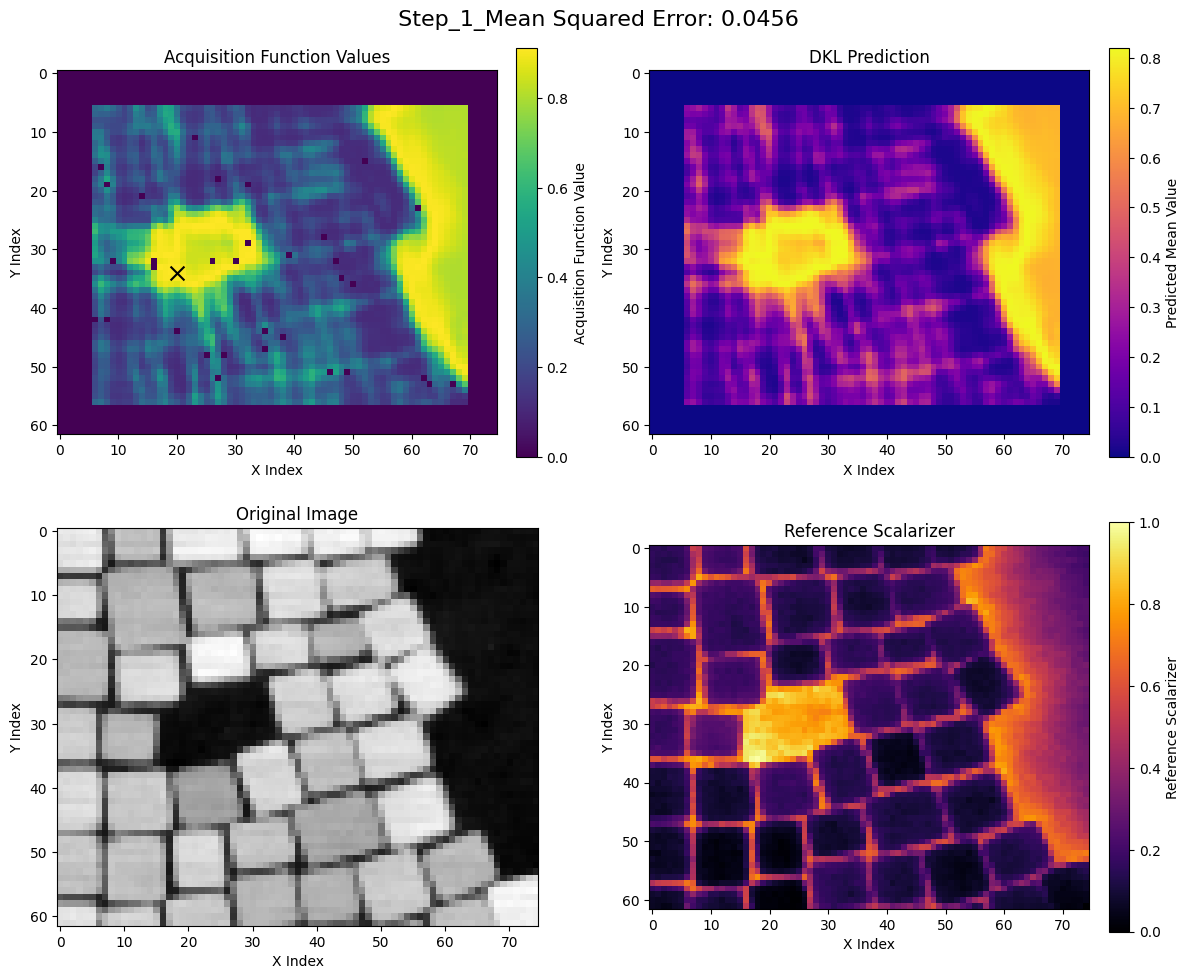

100%|██████████| 100/100 [00:04<00:00, 21.09it/s, init loss: 13205.6475, avg. loss [96-100]: 12489.9326]



Inferred GP kernel parameters
k_length         [1.5073999 2.4866998]
k_scale          0.22929999
noise            0.0235


In [ ]:
for i in range(budget):
  dkl = gpax.viDKL(data_dim, 2)
  dkl.fit(key1, np.array(X_measured), np.array(y_measured), num_steps=100, step_size=0.05)
  obj = gpax.acquisition.UCB(key2, dkl, np.array(X_unmeasured), beta=0.25, maximize=True)
  next_point_idx = obj.argmax()
  array_list, shape, dtype = mic_server.get_point_data(spectrum_image_index="Channel_001",x =  int(indices_measured[i, 0]), y = int(indices_measured[i, 1]))# note: the x and y should not be numpy objects
  measured_point = np.array(array_list, dtype=dtype).reshape(shape)
  measured_point = measured_point[e1a:e1b].sum() # scalarizer

  plot_acquisition_and_dkl_prediction(indices_unmeasured, obj, img, dkl, key1, X, indices_all, reference_y_pred, f"{out_dir}/dkl_pred_acq_{i}", i)



  X_measured = np.append(np.array(X_measured), np.array(X_unmeasured)[next_point_idx][None], 0)
  X_unmeasured = np.delete(np.array(X_unmeasured), next_point_idx, 0)
  y_measured_unnor = np.append(np.array(y_measured_unnor), measured_point)
  y_measured = norm_(np.asarray(y_measured_unnor))
  # y_unmeasured = np.delete(np.array(y_unmeasured), next_point_idx)
  indices_measured = np.append(np.array(indices_measured), np.array(indices_unmeasured)[next_point_idx][None], 0)
  indices_unmeasured = np.delete(np.array(indices_unmeasured), next_point_idx, 0)


